# **C19CXC**
## COVID-19 Chest X-Ray Classifier
##### Arman Jafarnezhad
---



## What are Coronaviruses?
Coronaviruses are a group of related RNA viruses that cause diseases in mammals and birds. In humans and birds, they cause respiratory tract infections that can range from mild to lethal. Mild illnesses in humans include some cases of the common cold (which is also caused by other viruses, predominantly rhinoviruses), while more lethal varieties can cause SARS, MERS, and COVID-19. In cows and pigs they cause diarrhea, while in mice they cause hepatitis and encephalomyelitis. Generally, there were no vaccines or antiviral drugs available for use against coronaviruses until the COVID-19 pandemic which broke out in late 2019.

## Coronavirus Symptoms & Diagnosis
The most common symptoms of Covid-19 are fever, fatigue, and dry cough. The sufferer may also have other symptoms such as bruising, runny nose, sore throat or diarrhea. But how does a doctor diagnose Coronavirus? For example, checking your body temperature is the easiest way to diagnose this disease, which is not accurate at all. Another way to diagnose the disease is to have a chest scan. That is, the chest is photographed and the health of the lungs is carefully monitored. Therefore, in this project, we develop a convolutional neural network that uses chest CT images to detect Coronavirus with deep learning.

# **Data Collection**
We need data to diagnose Coronavirus with deep learning. The Corona-positive CT scan dataset that we will use for this training was compiled by Joseph Cohen, PhD, University of Montreal. For Corona-negative data or normal samples we use the Chest X-Ray Images database from Kaggle. Eventually we will have a database with which we can train a deep network. But how do we build this database? The next section shows how to build our starting database.

## Create necessary folders

In [ ]:
! mkdir dataset
! mkdir /content/dataset/train
! mkdir /content/dataset/train/covid
! mkdir /content/dataset/train/normal
! mkdir /content/dataset/test
! mkdir /content/dataset/test/covid
! mkdir /content/dataset/test/normal

## Corona-positive dataset

In [ ]:
! git clone https://github.com/ieee8023/covid-chestxray-dataset

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 3622 (delta 3), reused 2 (delta 0), pack-reused 3614
Receiving objects: 100% (3622/3622), 632.88 MiB | 44.19 MiB/s, done.
Resolving deltas: 100% (1436/1436), done.
Checking out files: 100% (1173/1173), done.


## Corona-negative dataset
From [kaggle - my account](https://www.kaggle.com/me/account) press **create new token api** and upload downloaded file here.

In [ ]:
! pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"armanjr","key":"de6ccd0f2ae4d4073ec1bdf8562db158"}'}

In [ ]:
# --- Making root/kaggle folder ---
! mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# --- Downloading data ---
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
# --- Unzip ---
!unzip -q /content/chest-xray-pneumonia.zip

100% 2.29G/2.29G [00:30<00:00, 24.7MB/s]
100% 2.29G/2.29G [00:30<00:00, 80.9MB/s]


## Extract Covid-positive cases

In [ ]:
import pandas as pd

csvPath = '/content/covid-chestxray-dataset/metadata.csv'
df = pd.read_csv(csvPath)

In [ ]:
df.__len__()

950

In [ ]:
p_id = 0
cov_fn = []
allfiles = []

for (i, row) in df.iterrows():
	n_id = row["patientid"]

	if n_id != p_id and len(cov_fn)>0 and p_id != 0:
		allfiles.append(cov_fn)
		cov_fn = []
	if row["finding"] == "Pneumonia/Viral/COVID-19" and row["view"] == "PA":
		cov_fn.append(row["filename"])
		p_id = row["patientid"]

## Split data to train and test

In [ ]:
from sklearn.model_selection import train_test_split
	
x_train_c, x_test_c = train_test_split(allfiles, test_size=0.20, random_state=23)

## Save data to their folders

In [ ]:
import shutil

for img in sum(x_train_c, []):
    src = '/content/covid-chestxray-dataset/images/' + img
    dst = '/content/dataset/train/covid/' + img
    shutil.copy2(src, dst)

for img in sum(x_test_c, []):
    src = '/content/covid-chestxray-dataset/images/' + img
    dst = '/content/dataset/test/covid/' + img
    shutil.copy2(src, dst)

In [ ]:
import os
import cv2
import random

n_samples = len(sum(allfiles, []))
kaggle_data_path = '/content/chest_xray/train/NORMAL/'
output_path_train = '/content/dataset/train/normal/'
output_path_test = '/content/dataset/test/normal/'

filenames = os.listdir(kaggle_data_path)
random.seed(42)
filenames = random.sample(filenames, len(filenames))
for i in range(n_samples):
    n_image = cv2.imread(kaggle_data_path + filenames[i])
    if i < sum(x_train_c, []).__len__():
        cv2.imwrite(output_path_train + filenames[i], n_image)
    else:
        cv2.imwrite(output_path_test + filenames[i], n_image)

# **Data Preparation**
To pre-process CT scan data, we must first read the data. To do this, we first import the `os` library. Then, with the help of `os.listdir`, we list all the files that are in the normal and Covid-19 data path. Now we can loop this list and read the images one by one with `opencv` and the `cv2.imread` command.

In [ ]:
import os 
import numpy as np 

path = "/content/dataset" 
x_train_n = [] 
x_train_c = [] 
x_test_n = [] 
x_test_c = [] 

for p in os.listdir(path+ '/train/normal/'): 
    x_train_n.append(cv2.imread(path + '/train/normal/' + p)) 
for p in os.listdir(path+ '/train/covid/'): 
    x_train_c.append(cv2.imread(path + '/train/covid/' + p)) 
for p in os.listdir(path+ '/test/normal/'): 
    x_test_n.append(cv2.imread(path + '/test/normal/' + p)) 
for p in os.listdir(path+ '/test/covid/'): 
    x_test_c.append(cv2.imread(path + '/test/covid/' + p))

## Resize CT images
After reading the data, we need to resize all the images to 224 × 224. Why we should resize to this dimension? The reason for these changes we want to make is the [VGG network](https://www.quora.com/What-is-the-VGG-neural-network).

We want to use VGG network. As you know, the dimensions of the input images in VGG network are equal to 224 × 224. So we have to resize all our images to 224 × 224.

In [ ]:
for i in range(len(x_train_n)):
    x_train_n[i] = cv2.resize(x_train_n[i], (224, 224))
    x_train_c[i] = cv2.resize(x_train_c[i], (224, 224))

for i in range(len(x_test_n)):
    x_test_n[i] = cv2.resize(x_test_n[i], (224, 224))
    x_test_c[i] = cv2.resize(x_test_c[i], (224, 224))

These variables are `list` types. To make it easier for us to work with this data, we convert all 4 variables to `numpy-array`.

In [ ]:
x_train_n = np.array(x_train_n)
x_train_c = np.array(x_train_c)
x_test_n = np.array(x_test_n)
x_test_c = np.array(x_test_c)

In [ ]:
print(x_train_n.shape) 
print(x_train_c.shape) 
print(x_test_n.shape) 
print(x_test_c.shape)

(150, 224, 224, 3)
(150, 224, 224, 3)
(46, 224, 224, 3)
(46, 224, 224, 3)


## Combine Covid and Normal data


In [ ]:
x_train = np.concatenate((x_train_n, x_train_c))
x_test = np.concatenate((x_test_n, x_test_c))

## Change image ranges
We want all our data to be between 0 and 1.

In [ ]:
x_train = x_train / 255.0
x_test = x_test / 255.0

## Data labels
So far, our data is ready to go, but one thing is missing. We do not have a label. Labeling this data is simple. Each image is either Covid-19 or healthy. So we have two states. The labels are either 0 or 1. Therefore, we consider the healthy data label to be 0 and the Covid data to be 1.

In [ ]:
y_train_n = np.zeros(x_train_n.shape[0])
y_train_c = np.ones(x_train_c.shape[0])
y_test_n = np.zeros(x_test_n.shape[0])
y_test_c = np.ones(x_test_c.shape[0])

In [ ]:
y_train = np.concatenate((y_train_n, y_train_c))
y_test = np.concatenate((y_test_n, y_test_c))

In [ ]:
y_train = np.expand_dims(y_train, -1)
y_test = np.expand_dims(y_test, -1)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(300, 224, 224, 3)
(92, 224, 224, 3)
(300, 1)
(92, 1)


# **Define Model**
Now we begin building our deep learning model.

In [ ]:
# importing the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import argparse
import cv2
import os

In [ ]:
# initialize the learning rate, number of epochs to train for & batch
INIT_LR = 1e-3
EPOCHS = 50
BS = 8

## Data augmentation 
Data augmentation in data analysis are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data.

In [ ]:
trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

## VGG-16
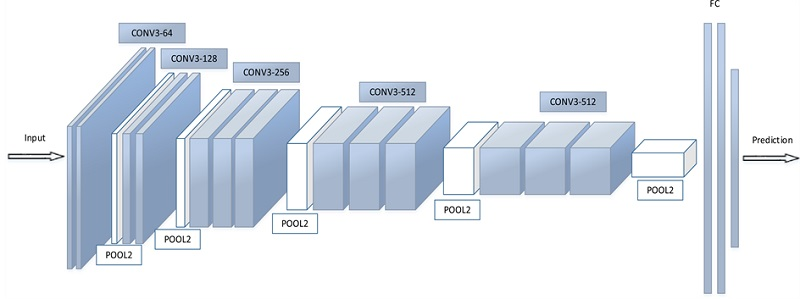

We want to use the VGG-16 network to detect Coronavirus with deep learning. VGG network is a deep network with many parameters. The VGG network architecture is shown in the image above. In this notebook we will not go into the details of the VGG network. This network has 130 million parameters. We are not going to use all these parameters during training. We want to use VGG-trained weights on the ImageNet database. That means we will actually use **transfer learning**.

To use the trained model VGG-16, we do not need to define it ourselves and then train it on ImageNet. With the help of *Tensorflow* and *Keras* we can call the VGG-16 network with its weights with only one line of code.

In [ ]:
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# Build the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)
# Place the head FC model on top of the base model. This will become the actual model we will train.
model = Model(inputs=baseModel.input, outputs=headModel)
# Loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


## Compile & Train
After defining the model, we need to compile it and then train it. But before that, we need to specify some values. We consider the learning rate to be `0.001`, the batch size to be `8`, and the number of epochs to be `50`. First we define the optimizer. The optimizer we want to use is `Adam`. We also want to use `LearningRateDecay`. That means we do not want the learning rate to be constant. Rather, we want to reduce the learning rate somewhat after passing a certain number of epochs.

In [ ]:
# Compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# Train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(x_train, y_train, batch_size=BS),
	steps_per_epoch=len(x_train) // BS,
	validation_data=(x_test, y_test),
	validation_steps=len(x_test) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
37/37 [==============================] - 5s 147ms/step - loss: 0.5948 - accuracy: 0.6849 - val_loss: 0.4968 - val_accuracy: 0.7174
Epoch 2/50
37/37 [==============================] - 4s 107ms/step - loss: 0.4465 - accuracy: 0.7911 - val_loss: 0.3739 - val_accuracy: 0.9130
Epoch 3/50
37/37 [==============================] - 4s 109ms/step - loss: 0.3277 - accuracy: 0.9007 - val_loss: 0.2573 - val_accuracy: 0.9565
Epoch 4/50
37/37 [==============================] - 4s 108ms/step - loss: 0.2639 - accuracy: 0.9349 - val_loss: 0.2024 - val_accuracy: 0.9565
Epoch 5/50
37/37 [==============================] - 4s 108ms/step - loss: 0.2276 - accuracy: 0.9349 - val_loss: 0.1731 - val_accuracy: 0.9565
Epoch 6/50
37/37 [==============================] - 4s 108ms/step - loss: 0.2071 - accuracy: 0.9384 - val_loss: 0.1553 - val_accuracy: 0.9674
Epoch 7/50
37/37 [====

# **Prediction & Results**
We must first see what the network does for test data. To do this, just use the command `model.predict`

In [ ]:
model.predict(x_test)

array([[3.52767020e-05],
       [2.14632927e-03],
       [4.35577426e-03],
       [2.06957757e-03],
       [1.62210269e-03],
       [9.78642725e-04],
       [1.73669934e-04],
       [2.57528911e-04],
       [4.59394359e-04],
       [8.50863568e-03],
       [4.14766977e-03],
       [5.63721813e-04],
       [1.21321634e-03],
       [2.07732301e-04],
       [5.01645030e-04],
       [1.67452963e-05],
       [1.64174251e-02],
       [1.11259105e-04],
       [1.95482910e-01],
       [1.15467538e-03],
       [3.90894897e-03],
       [6.36386037e-01],
       [8.72431975e-03],
       [1.29442476e-03],
       [2.05388246e-03],
       [2.95475853e-04],
       [1.94190201e-04],
       [5.26328571e-04],
       [5.34044229e-04],
       [2.42876675e-04],
       [6.37411431e-04],
       [1.19003979e-03],
       [3.57999350e-04],
       [8.49543838e-04],
       [8.55815379e-05],
       [5.01169998e-04],
       [7.29122490e-04],
       [7.90124297e-01],
       [7.34321438e-05],
       [4.28631727e-04],


## Confusion matrix
One way to evaluate network performance in classification problems is to use a confusion matrix. We can still use `ScikitLearn` to create the confusion matrix. To do this, call `sklearn.metrics` from the `confusion_matrix` command. Now we can calculate the **Accuracy**, **Sensitivity** and **Specificity** values using the confusion matrix.

In [ ]:
th = np.linspace(0.2, 0.8, 7)
all_cms = []
all_sens = []
all_spec = []
all_acc = []
for t in th:
    preds = model.predict(x_test)
    preds[preds > t] = 1
    preds[preds < t] = 0
    cm = confusion_matrix(y_test, preds)
    total = sum(sum(cm))
    acc = (cm[0, 0] + cm[1, 1]) / total
    all_acc.append(acc)
    sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    all_cms.append(cm)
    all_sens.append(sensitivity)
    all_spec.append(specificity)
print('Best accuracy: ', all_acc[np.argmax(all_acc)])
print('Threshold: ', th[np.argmax(all_acc)])
print('Confusion matrix: ', '\n', all_cms[np.argmax(all_acc)])
print('Sensitivity: ', all_sens[np.argmax(all_acc)])
print('Specificity: ', all_spec[np.argmax(all_acc)])



Best accuracy:  0.9782608695652174
Threshold:  0.2
Confusion matrix:  
 [[44  2]
 [ 0 46]]
Sensitivity:  0.9565217391304348
Specificity:  1.0
